# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

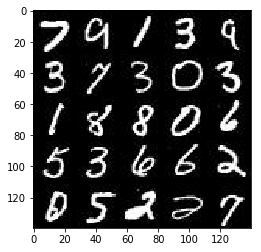

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

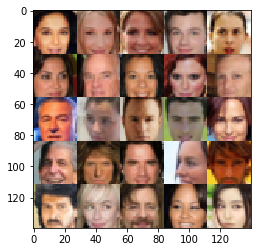

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, (), name='learn_rate')
    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
    
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        
        x1 = tf.layers.dense(z, 2*2*512)
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    tf.reset_default_graph()
    
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: z_sample, lr: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of every 10 steps, get the losses and print them out
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 25, z_input, img_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9604... Generator Loss: 3.6824
Epoch 1/2... Discriminator Loss: 0.5445... Generator Loss: 13.2152
Epoch 1/2... Discriminator Loss: 0.4109... Generator Loss: 3.1743
Epoch 1/2... Discriminator Loss: 3.0672... Generator Loss: 0.5779
Epoch 1/2... Discriminator Loss: 0.8548... Generator Loss: 0.7939
Epoch 1/2... Discriminator Loss: 0.7344... Generator Loss: 1.1041
Epoch 1/2... Discriminator Loss: 0.5669... Generator Loss: 6.1349
Epoch 1/2... Discriminator Loss: 0.0835... Generator Loss: 5.4793
Epoch 1/2... Discriminator Loss: 0.6436... Generator Loss: 2.1866
Epoch 1/2... Discriminator Loss: 0.7442... Generator Loss: 2.7239


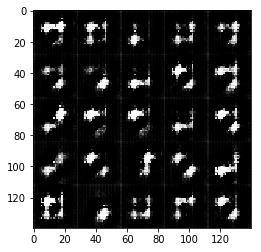

Epoch 1/2... Discriminator Loss: 0.6199... Generator Loss: 5.3166
Epoch 1/2... Discriminator Loss: 1.2183... Generator Loss: 2.0497
Epoch 1/2... Discriminator Loss: 0.7646... Generator Loss: 1.2738
Epoch 1/2... Discriminator Loss: 1.4089... Generator Loss: 0.6647
Epoch 1/2... Discriminator Loss: 2.4509... Generator Loss: 0.2968
Epoch 1/2... Discriminator Loss: 0.9230... Generator Loss: 2.6421
Epoch 1/2... Discriminator Loss: 0.4689... Generator Loss: 1.9158
Epoch 1/2... Discriminator Loss: 0.5472... Generator Loss: 1.4441
Epoch 1/2... Discriminator Loss: 0.3054... Generator Loss: 2.5556
Epoch 1/2... Discriminator Loss: 0.6988... Generator Loss: 1.1212


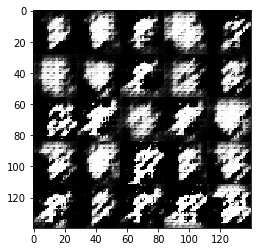

Epoch 1/2... Discriminator Loss: 0.6354... Generator Loss: 1.9584
Epoch 1/2... Discriminator Loss: 0.2315... Generator Loss: 2.8052
Epoch 1/2... Discriminator Loss: 0.2798... Generator Loss: 2.5414
Epoch 1/2... Discriminator Loss: 0.5181... Generator Loss: 1.6337
Epoch 1/2... Discriminator Loss: 0.1987... Generator Loss: 5.5793
Epoch 1/2... Discriminator Loss: 0.6421... Generator Loss: 1.3845
Epoch 1/2... Discriminator Loss: 2.0181... Generator Loss: 7.9900
Epoch 1/2... Discriminator Loss: 0.4359... Generator Loss: 2.3729
Epoch 1/2... Discriminator Loss: 0.7006... Generator Loss: 1.3932
Epoch 1/2... Discriminator Loss: 0.3705... Generator Loss: 2.4248


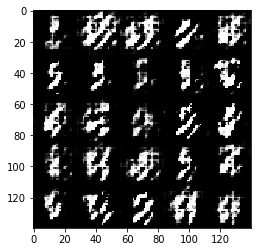

Epoch 1/2... Discriminator Loss: 1.2218... Generator Loss: 0.5034
Epoch 1/2... Discriminator Loss: 0.3680... Generator Loss: 2.4990
Epoch 1/2... Discriminator Loss: 0.8401... Generator Loss: 1.0165
Epoch 1/2... Discriminator Loss: 0.6358... Generator Loss: 3.8626
Epoch 1/2... Discriminator Loss: 0.4457... Generator Loss: 2.2186
Epoch 1/2... Discriminator Loss: 0.4061... Generator Loss: 2.1045
Epoch 1/2... Discriminator Loss: 0.7754... Generator Loss: 1.1113
Epoch 1/2... Discriminator Loss: 0.5418... Generator Loss: 2.9464
Epoch 1/2... Discriminator Loss: 0.4105... Generator Loss: 1.7712
Epoch 1/2... Discriminator Loss: 1.4226... Generator Loss: 4.8722


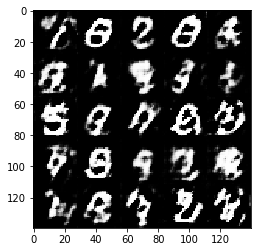

Epoch 1/2... Discriminator Loss: 0.7168... Generator Loss: 1.5136
Epoch 1/2... Discriminator Loss: 0.4589... Generator Loss: 1.9616
Epoch 1/2... Discriminator Loss: 0.9110... Generator Loss: 2.5386
Epoch 1/2... Discriminator Loss: 0.9948... Generator Loss: 0.7968
Epoch 1/2... Discriminator Loss: 0.6001... Generator Loss: 1.8220
Epoch 1/2... Discriminator Loss: 0.6020... Generator Loss: 1.4556
Epoch 1/2... Discriminator Loss: 0.6625... Generator Loss: 1.9447
Epoch 1/2... Discriminator Loss: 0.7308... Generator Loss: 1.9582
Epoch 1/2... Discriminator Loss: 0.9614... Generator Loss: 1.1013
Epoch 1/2... Discriminator Loss: 0.8808... Generator Loss: 0.9989


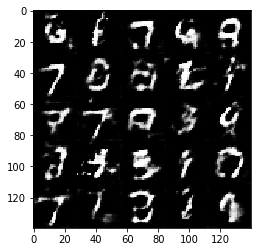

Epoch 1/2... Discriminator Loss: 0.7867... Generator Loss: 1.3654
Epoch 1/2... Discriminator Loss: 0.9857... Generator Loss: 2.4947
Epoch 1/2... Discriminator Loss: 0.7216... Generator Loss: 1.7591
Epoch 1/2... Discriminator Loss: 1.2295... Generator Loss: 2.9335
Epoch 1/2... Discriminator Loss: 0.9926... Generator Loss: 1.8168
Epoch 1/2... Discriminator Loss: 1.4640... Generator Loss: 0.4538
Epoch 1/2... Discriminator Loss: 0.6633... Generator Loss: 2.4033
Epoch 1/2... Discriminator Loss: 1.6883... Generator Loss: 0.6269
Epoch 1/2... Discriminator Loss: 0.8537... Generator Loss: 1.0031
Epoch 1/2... Discriminator Loss: 0.9741... Generator Loss: 0.8090


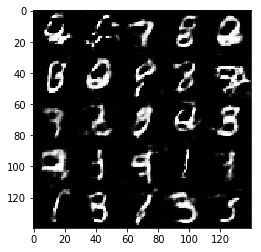

Epoch 1/2... Discriminator Loss: 0.7303... Generator Loss: 1.5094
Epoch 1/2... Discriminator Loss: 0.7345... Generator Loss: 1.7323
Epoch 1/2... Discriminator Loss: 2.5316... Generator Loss: 0.2170
Epoch 1/2... Discriminator Loss: 0.8559... Generator Loss: 0.9612
Epoch 1/2... Discriminator Loss: 1.3851... Generator Loss: 0.4003
Epoch 1/2... Discriminator Loss: 0.7605... Generator Loss: 1.2374
Epoch 1/2... Discriminator Loss: 0.7902... Generator Loss: 1.0472
Epoch 1/2... Discriminator Loss: 1.0544... Generator Loss: 0.8728
Epoch 1/2... Discriminator Loss: 1.1018... Generator Loss: 0.7079
Epoch 1/2... Discriminator Loss: 0.8801... Generator Loss: 1.2210


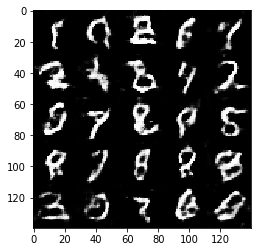

Epoch 1/2... Discriminator Loss: 0.9454... Generator Loss: 0.9292
Epoch 1/2... Discriminator Loss: 1.0477... Generator Loss: 2.8823
Epoch 1/2... Discriminator Loss: 1.6860... Generator Loss: 0.2924
Epoch 1/2... Discriminator Loss: 0.9506... Generator Loss: 1.9294
Epoch 1/2... Discriminator Loss: 2.4824... Generator Loss: 3.1126
Epoch 1/2... Discriminator Loss: 0.8446... Generator Loss: 1.0903
Epoch 1/2... Discriminator Loss: 0.8404... Generator Loss: 1.4030
Epoch 1/2... Discriminator Loss: 0.7826... Generator Loss: 1.1383
Epoch 1/2... Discriminator Loss: 1.2901... Generator Loss: 2.7850
Epoch 1/2... Discriminator Loss: 1.2012... Generator Loss: 0.6306


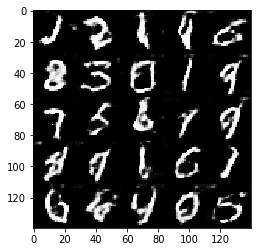

Epoch 1/2... Discriminator Loss: 0.7557... Generator Loss: 2.0784
Epoch 1/2... Discriminator Loss: 0.8704... Generator Loss: 0.9697
Epoch 1/2... Discriminator Loss: 0.8334... Generator Loss: 1.4968
Epoch 1/2... Discriminator Loss: 1.0104... Generator Loss: 0.7031
Epoch 1/2... Discriminator Loss: 0.9862... Generator Loss: 1.0270
Epoch 1/2... Discriminator Loss: 1.0174... Generator Loss: 1.0434
Epoch 1/2... Discriminator Loss: 0.9916... Generator Loss: 1.0466
Epoch 1/2... Discriminator Loss: 0.9355... Generator Loss: 0.9570
Epoch 1/2... Discriminator Loss: 1.1122... Generator Loss: 0.5679
Epoch 1/2... Discriminator Loss: 1.8598... Generator Loss: 0.2993


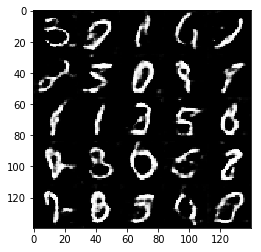

Epoch 1/2... Discriminator Loss: 1.0403... Generator Loss: 1.4929
Epoch 1/2... Discriminator Loss: 1.0768... Generator Loss: 0.6607
Epoch 1/2... Discriminator Loss: 1.0260... Generator Loss: 0.6747
Epoch 2/2... Discriminator Loss: 1.2045... Generator Loss: 0.6930
Epoch 2/2... Discriminator Loss: 1.1175... Generator Loss: 0.7390
Epoch 2/2... Discriminator Loss: 1.2356... Generator Loss: 2.3079
Epoch 2/2... Discriminator Loss: 0.8236... Generator Loss: 1.0381
Epoch 2/2... Discriminator Loss: 1.3864... Generator Loss: 2.8274
Epoch 2/2... Discriminator Loss: 1.0866... Generator Loss: 0.7260
Epoch 2/2... Discriminator Loss: 0.9886... Generator Loss: 1.5853


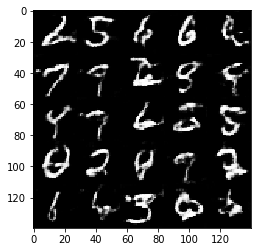

Epoch 2/2... Discriminator Loss: 0.9345... Generator Loss: 0.7897
Epoch 2/2... Discriminator Loss: 1.7840... Generator Loss: 0.4346
Epoch 2/2... Discriminator Loss: 1.2566... Generator Loss: 0.6539
Epoch 2/2... Discriminator Loss: 0.8696... Generator Loss: 1.0301
Epoch 2/2... Discriminator Loss: 1.1565... Generator Loss: 0.6157
Epoch 2/2... Discriminator Loss: 1.6015... Generator Loss: 2.0870
Epoch 2/2... Discriminator Loss: 1.2264... Generator Loss: 0.7098
Epoch 2/2... Discriminator Loss: 1.0063... Generator Loss: 1.0060
Epoch 2/2... Discriminator Loss: 1.7922... Generator Loss: 0.2514
Epoch 2/2... Discriminator Loss: 1.5397... Generator Loss: 0.3601


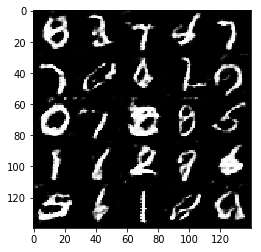

Epoch 2/2... Discriminator Loss: 0.8641... Generator Loss: 0.9679
Epoch 2/2... Discriminator Loss: 0.7876... Generator Loss: 1.6223
Epoch 2/2... Discriminator Loss: 1.2895... Generator Loss: 0.5205
Epoch 2/2... Discriminator Loss: 2.4083... Generator Loss: 0.1331
Epoch 2/2... Discriminator Loss: 1.3257... Generator Loss: 0.6030
Epoch 2/2... Discriminator Loss: 1.1943... Generator Loss: 2.5359
Epoch 2/2... Discriminator Loss: 1.1303... Generator Loss: 0.6302
Epoch 2/2... Discriminator Loss: 0.7716... Generator Loss: 1.2152
Epoch 2/2... Discriminator Loss: 1.0597... Generator Loss: 0.6158
Epoch 2/2... Discriminator Loss: 1.0318... Generator Loss: 1.4835


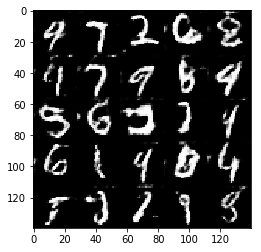

Epoch 2/2... Discriminator Loss: 0.8172... Generator Loss: 1.3139
Epoch 2/2... Discriminator Loss: 0.7453... Generator Loss: 0.9832
Epoch 2/2... Discriminator Loss: 1.8080... Generator Loss: 0.2809
Epoch 2/2... Discriminator Loss: 1.1309... Generator Loss: 0.8130
Epoch 2/2... Discriminator Loss: 1.0915... Generator Loss: 1.5467
Epoch 2/2... Discriminator Loss: 1.2902... Generator Loss: 0.4835
Epoch 2/2... Discriminator Loss: 1.0069... Generator Loss: 0.8196
Epoch 2/2... Discriminator Loss: 1.0868... Generator Loss: 0.6800
Epoch 2/2... Discriminator Loss: 1.1172... Generator Loss: 0.7298
Epoch 2/2... Discriminator Loss: 1.1549... Generator Loss: 0.6357


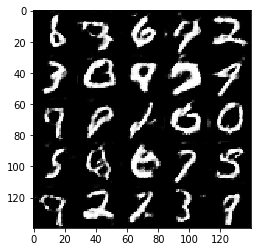

Epoch 2/2... Discriminator Loss: 0.5323... Generator Loss: 1.3179
Epoch 2/2... Discriminator Loss: 1.4331... Generator Loss: 0.3995
Epoch 2/2... Discriminator Loss: 1.0642... Generator Loss: 0.6573
Epoch 2/2... Discriminator Loss: 1.0468... Generator Loss: 2.7871
Epoch 2/2... Discriminator Loss: 0.9013... Generator Loss: 1.3930
Epoch 2/2... Discriminator Loss: 0.9127... Generator Loss: 0.7832
Epoch 2/2... Discriminator Loss: 0.8881... Generator Loss: 0.7878
Epoch 2/2... Discriminator Loss: 1.1138... Generator Loss: 0.5972
Epoch 2/2... Discriminator Loss: 1.5321... Generator Loss: 0.4170
Epoch 2/2... Discriminator Loss: 1.7440... Generator Loss: 0.3223


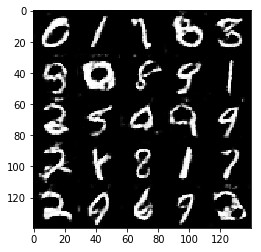

Epoch 2/2... Discriminator Loss: 0.9497... Generator Loss: 1.6829
Epoch 2/2... Discriminator Loss: 0.7772... Generator Loss: 1.6598
Epoch 2/2... Discriminator Loss: 1.4887... Generator Loss: 0.5368
Epoch 2/2... Discriminator Loss: 1.1689... Generator Loss: 0.5369
Epoch 2/2... Discriminator Loss: 1.4857... Generator Loss: 2.8858
Epoch 2/2... Discriminator Loss: 0.8584... Generator Loss: 0.8042
Epoch 2/2... Discriminator Loss: 1.0507... Generator Loss: 0.6829
Epoch 2/2... Discriminator Loss: 0.9253... Generator Loss: 0.8233
Epoch 2/2... Discriminator Loss: 1.0174... Generator Loss: 0.9679
Epoch 2/2... Discriminator Loss: 0.6375... Generator Loss: 1.1954


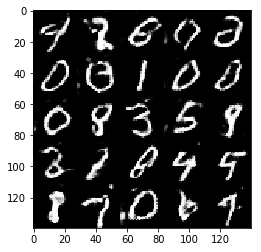

Epoch 2/2... Discriminator Loss: 1.4111... Generator Loss: 0.4453
Epoch 2/2... Discriminator Loss: 1.1365... Generator Loss: 1.7193
Epoch 2/2... Discriminator Loss: 1.5490... Generator Loss: 0.3514
Epoch 2/2... Discriminator Loss: 0.8811... Generator Loss: 1.1287
Epoch 2/2... Discriminator Loss: 0.7361... Generator Loss: 1.1224
Epoch 2/2... Discriminator Loss: 1.4531... Generator Loss: 0.4014
Epoch 2/2... Discriminator Loss: 0.5237... Generator Loss: 2.9089
Epoch 2/2... Discriminator Loss: 0.6419... Generator Loss: 1.3456
Epoch 2/2... Discriminator Loss: 0.9995... Generator Loss: 1.6731
Epoch 2/2... Discriminator Loss: 1.2305... Generator Loss: 1.4196


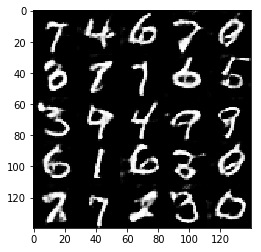

Epoch 2/2... Discriminator Loss: 0.6555... Generator Loss: 1.3620
Epoch 2/2... Discriminator Loss: 1.6281... Generator Loss: 0.3311
Epoch 2/2... Discriminator Loss: 0.8186... Generator Loss: 1.4573
Epoch 2/2... Discriminator Loss: 1.0235... Generator Loss: 0.7304
Epoch 2/2... Discriminator Loss: 0.7711... Generator Loss: 1.1704
Epoch 2/2... Discriminator Loss: 0.6882... Generator Loss: 1.0615
Epoch 2/2... Discriminator Loss: 1.2810... Generator Loss: 0.4947
Epoch 2/2... Discriminator Loss: 0.5870... Generator Loss: 2.1264
Epoch 2/2... Discriminator Loss: 1.8195... Generator Loss: 0.2715
Epoch 2/2... Discriminator Loss: 0.6056... Generator Loss: 1.2374


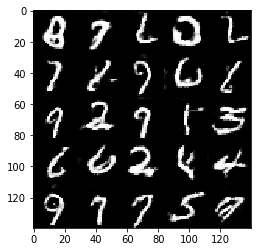

Epoch 2/2... Discriminator Loss: 0.7652... Generator Loss: 0.9516
Epoch 2/2... Discriminator Loss: 1.6316... Generator Loss: 0.4220
Epoch 2/2... Discriminator Loss: 1.2095... Generator Loss: 0.5703
Epoch 2/2... Discriminator Loss: 0.6846... Generator Loss: 1.9214
Epoch 2/2... Discriminator Loss: 1.8811... Generator Loss: 0.3009
Epoch 2/2... Discriminator Loss: 0.5468... Generator Loss: 1.8759
Epoch 2/2... Discriminator Loss: 0.7758... Generator Loss: 0.9034
Epoch 2/2... Discriminator Loss: 0.7067... Generator Loss: 1.0749
Epoch 2/2... Discriminator Loss: 1.0300... Generator Loss: 1.4722
Epoch 2/2... Discriminator Loss: 1.5869... Generator Loss: 0.3974


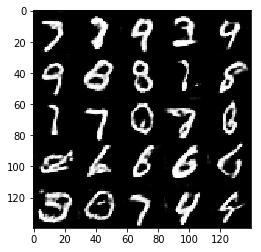

Epoch 2/2... Discriminator Loss: 1.2313... Generator Loss: 0.5117
Epoch 2/2... Discriminator Loss: 0.8724... Generator Loss: 0.8458
Epoch 2/2... Discriminator Loss: 1.2693... Generator Loss: 2.6897
Epoch 2/2... Discriminator Loss: 1.0332... Generator Loss: 0.7603
Epoch 2/2... Discriminator Loss: 0.7421... Generator Loss: 1.1517
Epoch 2/2... Discriminator Loss: 1.7120... Generator Loss: 2.9380
Epoch 2/2... Discriminator Loss: 1.1652... Generator Loss: 0.5425


IndexError: list index out of range

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.2148... Generator Loss: 7.4683
Epoch 1/1... Discriminator Loss: 0.4473... Generator Loss: 6.3223
Epoch 1/1... Discriminator Loss: 0.1290... Generator Loss: 7.7670
Epoch 1/1... Discriminator Loss: 0.2422... Generator Loss: 3.3968
Epoch 1/1... Discriminator Loss: 3.4340... Generator Loss: 0.0551
Epoch 1/1... Discriminator Loss: 0.6991... Generator Loss: 0.8508
Epoch 1/1... Discriminator Loss: 0.3080... Generator Loss: 1.6247
Epoch 1/1... Discriminator Loss: 0.0243... Generator Loss: 5.8939
Epoch 1/1... Discriminator Loss: 3.3086... Generator Loss: 8.4697
Epoch 1/1... Discriminator Loss: 0.3357... Generator Loss: 2.5305


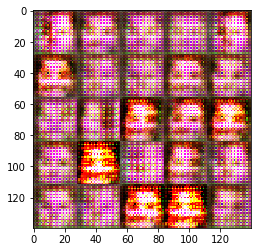

Epoch 1/1... Discriminator Loss: 0.2002... Generator Loss: 3.2244
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 3.1487
Epoch 1/1... Discriminator Loss: 0.1782... Generator Loss: 2.5795
Epoch 1/1... Discriminator Loss: 0.1443... Generator Loss: 3.6160
Epoch 1/1... Discriminator Loss: 0.8015... Generator Loss: 1.9835
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 1.0182
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.5124
Epoch 1/1... Discriminator Loss: 0.7262... Generator Loss: 1.5319
Epoch 1/1... Discriminator Loss: 0.5531... Generator Loss: 1.4092
Epoch 1/1... Discriminator Loss: 1.6289... Generator Loss: 0.9487


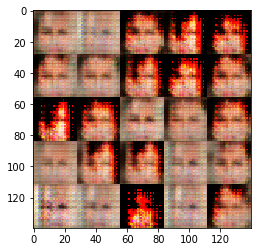

Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 0.3131
Epoch 1/1... Discriminator Loss: 0.7886... Generator Loss: 1.9450
Epoch 1/1... Discriminator Loss: 1.4956... Generator Loss: 0.5236
Epoch 1/1... Discriminator Loss: 0.2714... Generator Loss: 3.0223
Epoch 1/1... Discriminator Loss: 2.6686... Generator Loss: 0.0871
Epoch 1/1... Discriminator Loss: 0.7820... Generator Loss: 0.9207
Epoch 1/1... Discriminator Loss: 0.5088... Generator Loss: 1.2617
Epoch 1/1... Discriminator Loss: 0.6267... Generator Loss: 1.1515
Epoch 1/1... Discriminator Loss: 5.3009... Generator Loss: 6.1073
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 1.0101


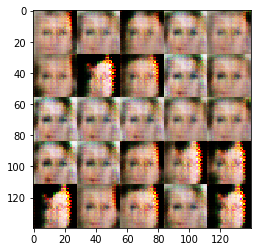

Epoch 1/1... Discriminator Loss: 0.7319... Generator Loss: 1.6092
Epoch 1/1... Discriminator Loss: 0.4592... Generator Loss: 1.8011
Epoch 1/1... Discriminator Loss: 0.2801... Generator Loss: 2.2999
Epoch 1/1... Discriminator Loss: 0.4277... Generator Loss: 2.8833
Epoch 1/1... Discriminator Loss: 0.7968... Generator Loss: 2.3898
Epoch 1/1... Discriminator Loss: 0.5718... Generator Loss: 2.0242
Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 1.0559
Epoch 1/1... Discriminator Loss: 0.9077... Generator Loss: 1.3095
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 3.1859
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.8558


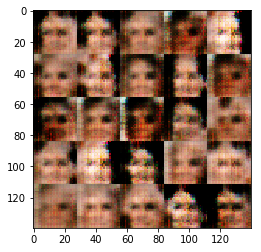

Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 1.4160
Epoch 1/1... Discriminator Loss: 2.3619... Generator Loss: 4.0815
Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.9298... Generator Loss: 0.2213
Epoch 1/1... Discriminator Loss: 0.5011... Generator Loss: 2.0546
Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 1.7788
Epoch 1/1... Discriminator Loss: 5.4523... Generator Loss: 5.2871
Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 0.9740... Generator Loss: 1.1830
Epoch 1/1... Discriminator Loss: 0.7915... Generator Loss: 1.2771


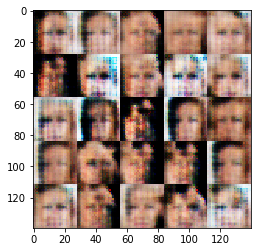

Epoch 1/1... Discriminator Loss: 0.7191... Generator Loss: 1.0299
Epoch 1/1... Discriminator Loss: 0.6844... Generator Loss: 1.9511
Epoch 1/1... Discriminator Loss: 0.6889... Generator Loss: 1.5347
Epoch 1/1... Discriminator Loss: 1.6276... Generator Loss: 3.5377
Epoch 1/1... Discriminator Loss: 0.9076... Generator Loss: 1.1151
Epoch 1/1... Discriminator Loss: 1.0180... Generator Loss: 1.2252
Epoch 1/1... Discriminator Loss: 0.7111... Generator Loss: 1.7800
Epoch 1/1... Discriminator Loss: 0.8545... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 0.4419... Generator Loss: 2.0261
Epoch 1/1... Discriminator Loss: 0.5067... Generator Loss: 1.4651


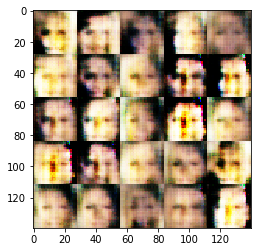

Epoch 1/1... Discriminator Loss: 1.8356... Generator Loss: 0.3654
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 2.2542
Epoch 1/1... Discriminator Loss: 0.7932... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 0.8294... Generator Loss: 1.4284
Epoch 1/1... Discriminator Loss: 2.4718... Generator Loss: 3.8202
Epoch 1/1... Discriminator Loss: 0.5098... Generator Loss: 1.4661
Epoch 1/1... Discriminator Loss: 0.3925... Generator Loss: 2.5017
Epoch 1/1... Discriminator Loss: 0.3590... Generator Loss: 1.5206


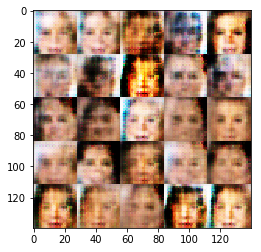

Epoch 1/1... Discriminator Loss: 0.7395... Generator Loss: 2.9368
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.4628
Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 1.2355
Epoch 1/1... Discriminator Loss: 0.7813... Generator Loss: 1.2729
Epoch 1/1... Discriminator Loss: 0.6955... Generator Loss: 0.9744
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 1.6986
Epoch 1/1... Discriminator Loss: 0.5128... Generator Loss: 1.4284
Epoch 1/1... Discriminator Loss: 0.7206... Generator Loss: 1.0477
Epoch 1/1... Discriminator Loss: 0.6312... Generator Loss: 1.3339
Epoch 1/1... Discriminator Loss: 2.2606... Generator Loss: 4.2623


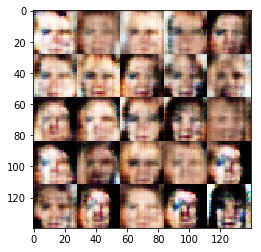

Epoch 1/1... Discriminator Loss: 0.3678... Generator Loss: 2.2133
Epoch 1/1... Discriminator Loss: 0.9317... Generator Loss: 0.9493
Epoch 1/1... Discriminator Loss: 1.5612... Generator Loss: 2.8249
Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 0.9063... Generator Loss: 2.3716
Epoch 1/1... Discriminator Loss: 0.4277... Generator Loss: 2.0512
Epoch 1/1... Discriminator Loss: 2.9194... Generator Loss: 4.4284
Epoch 1/1... Discriminator Loss: 0.8336... Generator Loss: 1.1790
Epoch 1/1... Discriminator Loss: 0.7314... Generator Loss: 1.9031
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 1.5675


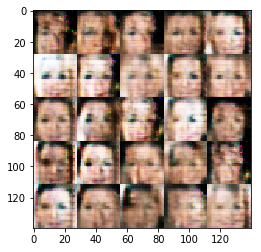

Epoch 1/1... Discriminator Loss: 0.7806... Generator Loss: 0.9214
Epoch 1/1... Discriminator Loss: 1.5925... Generator Loss: 1.6658
Epoch 1/1... Discriminator Loss: 0.6280... Generator Loss: 0.9411
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 2.2428
Epoch 1/1... Discriminator Loss: 5.3634... Generator Loss: 6.6816
Epoch 1/1... Discriminator Loss: 0.4399... Generator Loss: 1.7341
Epoch 1/1... Discriminator Loss: 0.8029... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 0.9708... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 0.8591... Generator Loss: 2.8366


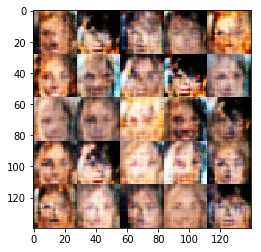

Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 0.5526
Epoch 1/1... Discriminator Loss: 0.2261... Generator Loss: 3.8012
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 0.4568
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 1.6963... Generator Loss: 1.7921
Epoch 1/1... Discriminator Loss: 0.7498... Generator Loss: 1.8996
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.4659
Epoch 1/1... Discriminator Loss: 1.4938... Generator Loss: 3.2877
Epoch 1/1... Discriminator Loss: 0.5039... Generator Loss: 1.1909


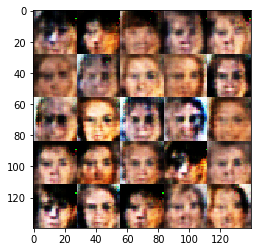

Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 1.2713
Epoch 1/1... Discriminator Loss: 1.0817... Generator Loss: 0.5542
Epoch 1/1... Discriminator Loss: 0.7449... Generator Loss: 2.2475
Epoch 1/1... Discriminator Loss: 0.3270... Generator Loss: 2.3543
Epoch 1/1... Discriminator Loss: 0.3530... Generator Loss: 2.5660
Epoch 1/1... Discriminator Loss: 2.3018... Generator Loss: 0.1864
Epoch 1/1... Discriminator Loss: 0.7692... Generator Loss: 2.0352
Epoch 1/1... Discriminator Loss: 0.8277... Generator Loss: 1.3190
Epoch 1/1... Discriminator Loss: 1.5710... Generator Loss: 0.3523
Epoch 1/1... Discriminator Loss: 0.8209... Generator Loss: 0.8188


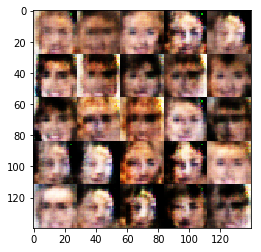

Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 0.8306... Generator Loss: 0.8931
Epoch 1/1... Discriminator Loss: 0.8807... Generator Loss: 1.0551
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 2.5835
Epoch 1/1... Discriminator Loss: 0.9625... Generator Loss: 1.8210
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 0.4202... Generator Loss: 1.4023
Epoch 1/1... Discriminator Loss: 1.5879... Generator Loss: 2.1114
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 0.8605
Epoch 1/1... Discriminator Loss: 1.0052... Generator Loss: 3.8934


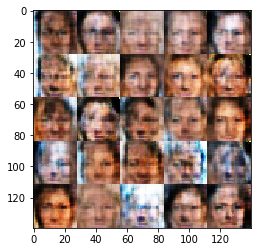

Epoch 1/1... Discriminator Loss: 0.7775... Generator Loss: 2.5605
Epoch 1/1... Discriminator Loss: 1.0006... Generator Loss: 1.3998
Epoch 1/1... Discriminator Loss: 0.9305... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 0.4529... Generator Loss: 1.8485
Epoch 1/1... Discriminator Loss: 0.3542... Generator Loss: 1.5899
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 1.1296
Epoch 1/1... Discriminator Loss: 0.6983... Generator Loss: 1.0930
Epoch 1/1... Discriminator Loss: 0.8666... Generator Loss: 3.4531
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 0.6134
Epoch 1/1... Discriminator Loss: 0.5667... Generator Loss: 1.3803


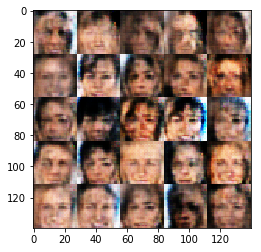

Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 0.4009... Generator Loss: 1.7332
Epoch 1/1... Discriminator Loss: 2.0910... Generator Loss: 3.2746
Epoch 1/1... Discriminator Loss: 0.5788... Generator Loss: 1.0814
Epoch 1/1... Discriminator Loss: 0.6400... Generator Loss: 1.2990
Epoch 1/1... Discriminator Loss: 0.8699... Generator Loss: 1.1092
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 1.2885
Epoch 1/1... Discriminator Loss: 0.6803... Generator Loss: 1.1741
Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 1.2050


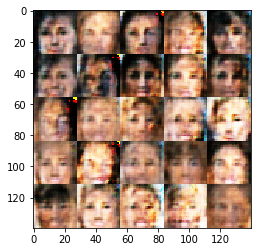

Epoch 1/1... Discriminator Loss: 2.0081... Generator Loss: 3.1971
Epoch 1/1... Discriminator Loss: 0.6757... Generator Loss: 1.2808
Epoch 1/1... Discriminator Loss: 0.2805... Generator Loss: 1.8397
Epoch 1/1... Discriminator Loss: 1.7133... Generator Loss: 2.2923
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 0.7417... Generator Loss: 1.3964
Epoch 1/1... Discriminator Loss: 0.6150... Generator Loss: 1.7552
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 0.5547... Generator Loss: 2.2083
Epoch 1/1... Discriminator Loss: 0.9802... Generator Loss: 0.8756


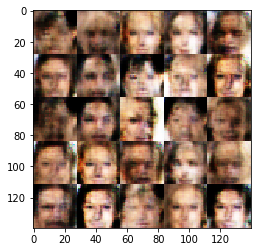

Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 1.2308
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 1.4701
Epoch 1/1... Discriminator Loss: 0.7534... Generator Loss: 1.1393
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.4412
Epoch 1/1... Discriminator Loss: 1.7162... Generator Loss: 0.2683
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 1.1035
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 1.0427
Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 0.9616
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.0780... Generator Loss: 1.0407


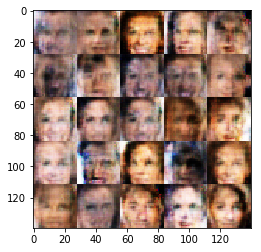

Epoch 1/1... Discriminator Loss: 0.8933... Generator Loss: 1.1856
Epoch 1/1... Discriminator Loss: 1.8321... Generator Loss: 0.2886
Epoch 1/1... Discriminator Loss: 0.8867... Generator Loss: 1.0663
Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 1.0509
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 1.7187
Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 2.1477... Generator Loss: 2.6732
Epoch 1/1... Discriminator Loss: 0.7674... Generator Loss: 1.4432
Epoch 1/1... Discriminator Loss: 0.9609... Generator Loss: 0.9780


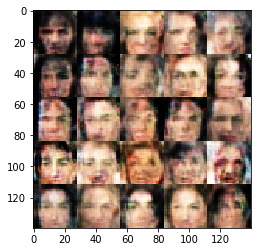

Epoch 1/1... Discriminator Loss: 0.6594... Generator Loss: 1.2651
Epoch 1/1... Discriminator Loss: 0.7609... Generator Loss: 0.9177
Epoch 1/1... Discriminator Loss: 0.7290... Generator Loss: 1.1730
Epoch 1/1... Discriminator Loss: 0.7164... Generator Loss: 1.0870
Epoch 1/1... Discriminator Loss: 1.1951... Generator Loss: 2.5696
Epoch 1/1... Discriminator Loss: 0.8977... Generator Loss: 1.4187
Epoch 1/1... Discriminator Loss: 0.9115... Generator Loss: 1.2601
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.4977
Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 1.5238
Epoch 1/1... Discriminator Loss: 3.6101... Generator Loss: 0.0422


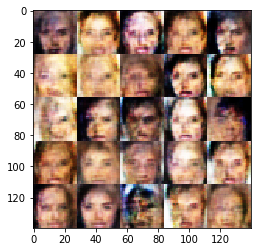

Epoch 1/1... Discriminator Loss: 0.8220... Generator Loss: 1.0572
Epoch 1/1... Discriminator Loss: 2.0912... Generator Loss: 0.2502
Epoch 1/1... Discriminator Loss: 0.9272... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 0.9404... Generator Loss: 2.3999
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 0.8986... Generator Loss: 1.1549
Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 1.7572
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.4219
Epoch 1/1... Discriminator Loss: 1.7918... Generator Loss: 0.2886
Epoch 1/1... Discriminator Loss: 2.2728... Generator Loss: 0.2044


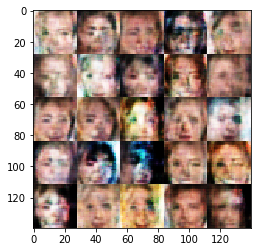

Epoch 1/1... Discriminator Loss: 0.7730... Generator Loss: 2.2045
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 1.5597
Epoch 1/1... Discriminator Loss: 0.8413... Generator Loss: 1.8556
Epoch 1/1... Discriminator Loss: 0.8723... Generator Loss: 1.7987
Epoch 1/1... Discriminator Loss: 0.6084... Generator Loss: 1.4740
Epoch 1/1... Discriminator Loss: 0.4210... Generator Loss: 2.5656
Epoch 1/1... Discriminator Loss: 0.7974... Generator Loss: 1.3423
Epoch 1/1... Discriminator Loss: 0.4443... Generator Loss: 1.8794
Epoch 1/1... Discriminator Loss: 2.3091... Generator Loss: 0.1391
Epoch 1/1... Discriminator Loss: 0.4247... Generator Loss: 2.1163


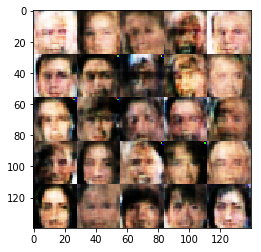

Epoch 1/1... Discriminator Loss: 0.7331... Generator Loss: 1.3802
Epoch 1/1... Discriminator Loss: 0.5681... Generator Loss: 1.7295
Epoch 1/1... Discriminator Loss: 0.6930... Generator Loss: 3.9615
Epoch 1/1... Discriminator Loss: 0.2619... Generator Loss: 2.7706
Epoch 1/1... Discriminator Loss: 1.6278... Generator Loss: 0.3091
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 1.3972
Epoch 1/1... Discriminator Loss: 0.4111... Generator Loss: 1.7895
Epoch 1/1... Discriminator Loss: 1.7313... Generator Loss: 2.7195
Epoch 1/1... Discriminator Loss: 0.8345... Generator Loss: 1.4769
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 2.2427


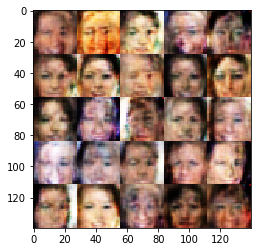

Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 1.8861
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 1.0118
Epoch 1/1... Discriminator Loss: 0.3589... Generator Loss: 1.7489
Epoch 1/1... Discriminator Loss: 0.3385... Generator Loss: 2.3417
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.4105
Epoch 1/1... Discriminator Loss: 0.5710... Generator Loss: 1.3804
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 2.5204
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 1.2087
Epoch 1/1... Discriminator Loss: 1.7145... Generator Loss: 0.3325
Epoch 1/1... Discriminator Loss: 0.7357... Generator Loss: 3.2569


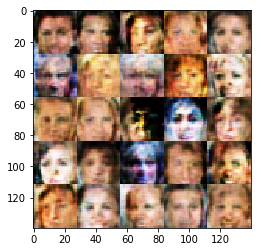

Epoch 1/1... Discriminator Loss: 0.8486... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 3.1854... Generator Loss: 0.0624
Epoch 1/1... Discriminator Loss: 0.3887... Generator Loss: 1.7355
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 0.8944
Epoch 1/1... Discriminator Loss: 0.7956... Generator Loss: 1.5867
Epoch 1/1... Discriminator Loss: 0.7434... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 2.3980... Generator Loss: 4.4109
Epoch 1/1... Discriminator Loss: 1.4999... Generator Loss: 0.5810
Epoch 1/1... Discriminator Loss: 0.6524... Generator Loss: 1.7050
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 1.0577


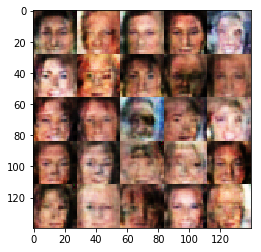

Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 0.5726
Epoch 1/1... Discriminator Loss: 0.6909... Generator Loss: 1.4762
Epoch 1/1... Discriminator Loss: 0.8432... Generator Loss: 0.9496
Epoch 1/1... Discriminator Loss: 0.5366... Generator Loss: 1.4037
Epoch 1/1... Discriminator Loss: 0.7919... Generator Loss: 1.3703
Epoch 1/1... Discriminator Loss: 0.8816... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 0.5248... Generator Loss: 1.8418
Epoch 1/1... Discriminator Loss: 1.5255... Generator Loss: 1.0604
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 2.5895
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 2.8303


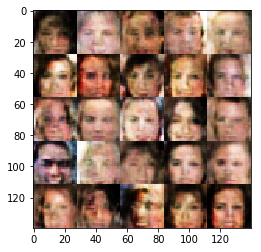

Epoch 1/1... Discriminator Loss: 1.0208... Generator Loss: 5.0074
Epoch 1/1... Discriminator Loss: 0.0990... Generator Loss: 2.9671
Epoch 1/1... Discriminator Loss: 0.2460... Generator Loss: 2.3202
Epoch 1/1... Discriminator Loss: 1.8351... Generator Loss: 4.4706
Epoch 1/1... Discriminator Loss: 0.4577... Generator Loss: 1.7679
Epoch 1/1... Discriminator Loss: 0.5636... Generator Loss: 1.4626
Epoch 1/1... Discriminator Loss: 0.2179... Generator Loss: 2.1847
Epoch 1/1... Discriminator Loss: 0.0701... Generator Loss: 3.0750
Epoch 1/1... Discriminator Loss: 5.5245... Generator Loss: 5.6035
Epoch 1/1... Discriminator Loss: 0.8071... Generator Loss: 1.4042


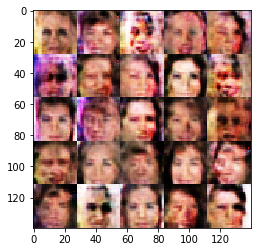

Epoch 1/1... Discriminator Loss: 0.7571... Generator Loss: 1.0397
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 0.9698... Generator Loss: 1.0830
Epoch 1/1... Discriminator Loss: 1.5612... Generator Loss: 0.4006
Epoch 1/1... Discriminator Loss: 0.8586... Generator Loss: 1.1043
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 1.0749
Epoch 1/1... Discriminator Loss: 0.8937... Generator Loss: 1.9684
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 2.4124
Epoch 1/1... Discriminator Loss: 0.9730... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 0.8933... Generator Loss: 1.3317


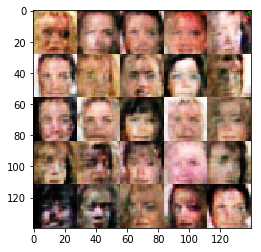

Epoch 1/1... Discriminator Loss: 0.9782... Generator Loss: 1.2869
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 0.9403
Epoch 1/1... Discriminator Loss: 0.8644... Generator Loss: 1.5040
Epoch 1/1... Discriminator Loss: 1.0742... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.5211... Generator Loss: 3.3141
Epoch 1/1... Discriminator Loss: 0.7429... Generator Loss: 1.4870
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 0.8636... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.7608... Generator Loss: 0.3200
Epoch 1/1... Discriminator Loss: 0.8752... Generator Loss: 1.3165


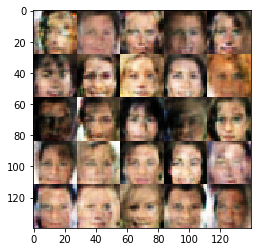

Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 2.1978
Epoch 1/1... Discriminator Loss: 0.8924... Generator Loss: 1.1693
Epoch 1/1... Discriminator Loss: 0.5983... Generator Loss: 1.4013
Epoch 1/1... Discriminator Loss: 0.6735... Generator Loss: 1.0687
Epoch 1/1... Discriminator Loss: 0.5738... Generator Loss: 1.9992
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 2.0193
Epoch 1/1... Discriminator Loss: 0.6065... Generator Loss: 1.0564
Epoch 1/1... Discriminator Loss: 0.9149... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.8658... Generator Loss: 0.2948
Epoch 1/1... Discriminator Loss: 0.8446... Generator Loss: 1.5500


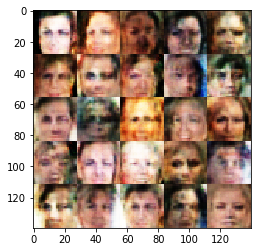

IndexError: list index out of range

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.